In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract, when, lit
from pyspark.sql.types import FloatType
from pyspark.ml.feature import (
    MinMaxScaler, StringIndexer, CountVectorizer, 
    VectorAssembler, Tokenizer, HashingTF, IDF
)
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
spark = SparkSession.builder \
    .appName("FeatureEngineering") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/23 00:11:59 INFO SparkEnv: Registering MapOutputTracker
25/01/23 00:11:59 INFO SparkEnv: Registering BlockManagerMaster
25/01/23 00:11:59 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/01/23 00:11:59 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
cleaned = #GCS file path
reviews_sdf = spark.read.parquet(cleaned).sample(False, 0.10)


In [4]:
reviews_sdf = reviews_sdf.withColumn("audience_rating", col("audience_rating").cast(FloatType()))


In [5]:
reviews_sdf = reviews_sdf.withColumn(
    "movie_runtime",
    when(col("movie_runtime").isNull(), lit("0h 0m"))
    .when(col("movie_runtime") == "", lit("0h 0m"))
    .otherwise(col("movie_runtime"))
)
reviews_sdf = reviews_sdf.withColumn(
    "hours",
    when(col("movie_runtime").isNotNull(),
         regexp_extract(col("movie_runtime"), r"(\d+)h", 1).cast("int")).otherwise(0)
)
reviews_sdf = reviews_sdf.withColumn(
    "minutes",
    when(col("movie_runtime").isNotNull(),
         regexp_extract(col("movie_runtime"), r"(\d+)m", 1).cast("int")).otherwise(0)
)
reviews_sdf = reviews_sdf.fillna({"hours": 0, "minutes": 0})
reviews_sdf = reviews_sdf.withColumn("movie_runtime_minutes", (col("hours") * 60 + col("minutes"))).drop("hours", "minutes")


In [6]:
assembler_score = VectorAssembler(inputCols = ["audience_score"], outputCol = "audience_score_vector")
scaler = MinMaxScaler(inputCol = "audience_score_vector", outputCol = "audience_score_scaled")
runtime_assembler = VectorAssembler(inputCols = ["movie_runtime_minutes"], outputCol = "runtime_vector")
runtime_scaler = MinMaxScaler(inputCol = "runtime_vector", outputCol = "total_runtime")
tokenizer = Tokenizer(inputCol = "audience_quote", outputCol = "audience_words")
hashing_tf = HashingTF(inputCol = "audience_words", outputCol = "raw_features", numFeatures = 1000)
idf = IDF(inputCol = "raw_features", outputCol = "tfidf_features")
day_of_week_indexer = StringIndexer(inputCol = "audience_creationDate", outputCol = "review_day_of_week")


In [7]:
feature_columns = ["audience_score_scaled", "total_runtime", "audience_rating", "tfidf_features", "review_day_of_week"]
assembler = VectorAssembler(inputCols = feature_columns, outputCol = "final_features")


In [8]:
pipeline = Pipeline(stages = [assembler_score, scaler, runtime_assembler, runtime_scaler, tokenizer, hashing_tf, idf, day_of_week_indexer, assembler])

In [9]:
model = pipeline.fit(reviews_sdf)
processed_data = model.transform(reviews_sdf)


In [10]:
indexer = StringIndexer(inputCol = "audience_sentiment", outputCol = "indexed_audience_sentiment")
processed_data = indexer.fit(processed_data).transform(processed_data)


In [11]:
train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed = 40)

In [12]:
train_data = train_data.withColumnRenamed("indexed_audience_sentiment", "label")
test_data = test_data.withColumnRenamed("indexed_audience_sentiment", "label")

In [13]:
lr = LogisticRegression(featuresCol = "final_features", labelCol = "label")
lr_model = lr.fit(train_data)

25/01/23 00:12:50 WARN DAGScheduler: Broadcasting large task binary with size 1375.3 KiB
25/01/23 00:13:10 WARN DAGScheduler: Broadcasting large task binary with size 1376.4 KiB
25/01/23 00:13:11 WARN DAGScheduler: Broadcasting large task binary with size 1375.8 KiB
25/01/23 00:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1377.0 KiB
25/01/23 00:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1375.8 KiB
25/01/23 00:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1377.0 KiB
25/01/23 00:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1375.8 KiB
25/01/23 00:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1377.0 KiB
25/01/23 00:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1375.8 KiB
25/01/23 00:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1377.0 KiB
25/01/23 00:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1375.8 KiB
25/01/23 00:13:30 WAR

In [14]:
predictions = lr_model.transform(test_data)
predictions.select("final_features", "audience_sentiment", "prediction").show(truncate = False)

25/01/23 00:13:41 WARN DAGScheduler: Broadcasting large task binary with size 1367.2 KiB


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
evaluator = MulticlassClassificationEvaluator(
    labelCol = "label", predictionCol = "prediction", metricName = "accuracy")

accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy}")

25/01/23 00:13:47 WARN DAGScheduler: Broadcasting large task binary with size 1386.7 KiB


Test Accuracy: 1.0


In [16]:
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.maxIter, [10, 20]).build()
crossval = CrossValidator(estimator = lr, estimatorParamMaps=paramGrid, evaluator = evaluator, numFolds = 3)
cvModel = crossval.fit(train_data)

25/01/22 23:44:44 WARN DAGScheduler: Broadcasting large task binary with size 1425.6 KiB
25/01/22 23:45:35 WARN DAGScheduler: Broadcasting large task binary with size 1461.0 KiB
25/01/22 23:45:37 WARN DAGScheduler: Broadcasting large task binary with size 1462.2 KiB
25/01/22 23:45:37 WARN DAGScheduler: Broadcasting large task binary with size 1461.6 KiB
25/01/22 23:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1462.8 KiB
25/01/22 23:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1461.6 KiB
25/01/22 23:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1462.8 KiB
25/01/22 23:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1461.6 KiB
25/01/22 23:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1462.8 KiB
25/01/22 23:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1461.6 KiB
25/01/22 23:45:40 WARN DAGScheduler: Broadcasting large task binary with size 1462.8 KiB
25/01/22 23:45:40 WAR

In [ ]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import DenseVector
from pyspark.sql.types import DoubleType

def extract_positive_probability(probability):
    dense_prob = DenseVector(probability.values)  
    return float(dense_prob[1])  

extract_probability_udf = udf(extract_positive_probability, DoubleType())

predictions = predictions.withColumn("positive_probability", extract_probability_udf(col("probability")))

predictions.select("audience_sentiment", "prediction", "positive_probability").write.csv(
    #GCS file path, header=True, mode="overwrite"
)

In [ ]:
processed_data.write.parquet(#GCS file path)

lr_model.save(#GCS file path)


In [79]:
pandas_df = predictions.limit(10000).toPandas()

25/01/23 05:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1511.6 KiB


In [45]:
print(pandas_df)

      review_count  movieYear  movieTitle  audience_score audience_sentiment  \
0             3521       1987  Hellraiser            73.0           positive   
1             3521       1987  Hellraiser            73.0           positive   
2             3526       1992     Newsies            88.0           positive   
3             3526       1992     Newsies            88.0           positive   
4             3526       1992     Newsies            88.0           positive   
...            ...        ...         ...             ...                ...   
1995          6897       2004   Alexander            35.0           negative   
1996          6897       2004   Alexander            35.0           negative   
1997          6897       2004   Alexander            35.0           negative   
1998          6897       2004   Alexander            35.0           negative   
1999          6897       2004   Alexander            35.0           negative   

     movie_runtime  audience_rating  \


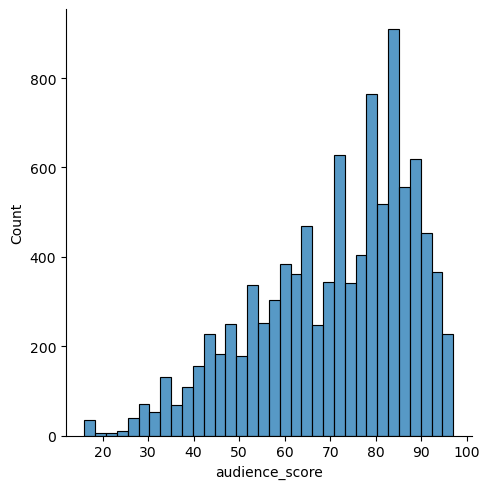

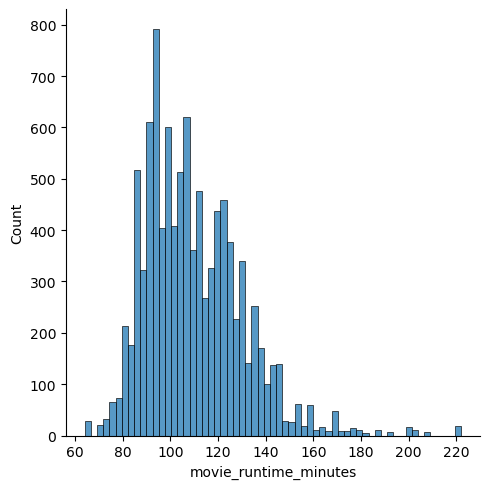

In [80]:
import seaborn as sns
import pandas as pd

sns.displot(pandas_df["audience_score"])
sns.displot(pandas_df["movie_runtime_minutes"])

In [49]:
pandas_df.dtypes

review_count               int64
movieYear                  int32
movieTitle                object
audience_score           float64
audience_sentiment        object
movie_runtime             object
audience_rating          float32
audience_quote            object
audience_creationDate     object
movie_runtime_minutes      int32
audience_score_vector     object
audience_score_scaled     object
runtime_vector            object
total_runtime             object
audience_words            object
raw_features              object
tfidf_features            object
review_day_of_week       float64
final_features            object
label                    float64
rawPrediction             object
probability               object
prediction               float64
dtype: object

<Axes: xlabel='movieYear', ylabel='prediction'>

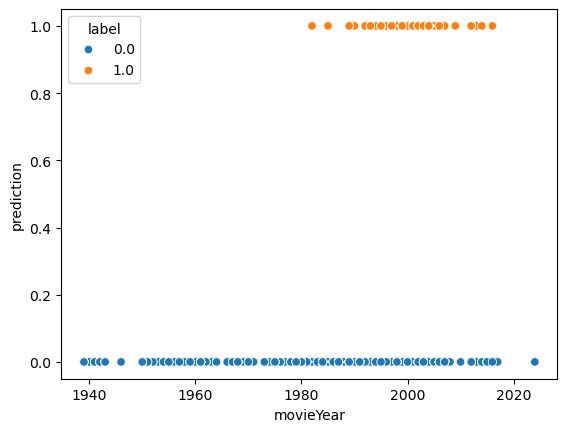

In [98]:
sns.scatterplot(x = "movieYear", y = "prediction", hue = "label", data = pandas_df)

<Axes: xlabel='audience_score', ylabel='prediction'>

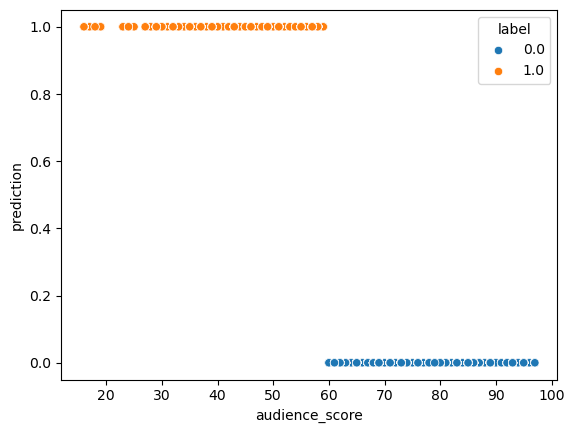

In [91]:
sns.scatterplot(x = "audience_score", y = "prediction", hue = "label", data = pandas_df)

In [82]:
lr_model.coefficients

for i, feature in enumerate(feature_columns):
    print(f"{feature}: {lr_model.coefficients[i]}")

audience_score_scaled: -2898.8230465102656
total_runtime: -23.692273148524855
audience_rating: -0.09852498641702695
tfidf_features: -0.06416878553479084
review_day_of_week: -0.047321631487960675


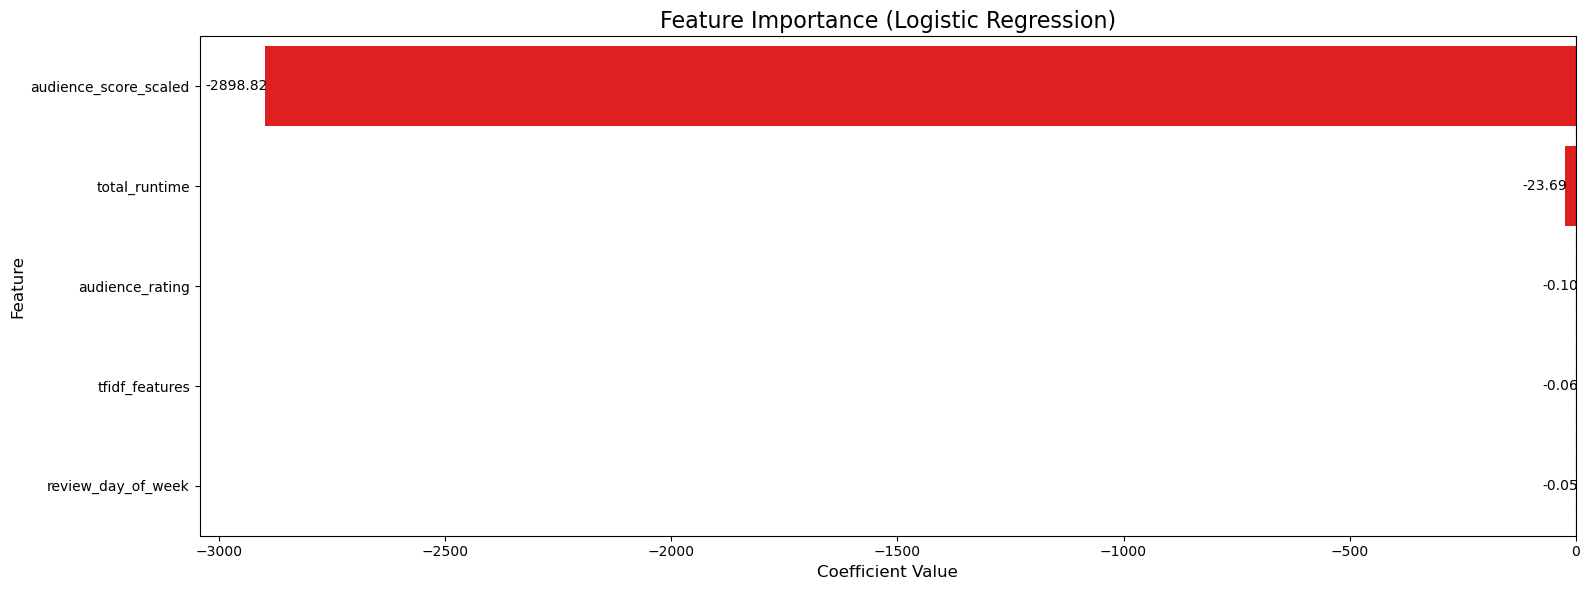

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {"Feature": [
        "audience_score_scaled",
        "total_runtime",
        "audience_rating",
        "tfidf_features",
        "review_day_of_week"
    ],
    "Importance": [
        -2898.8230465102656,
        -23.692273148524855,
        -0.09852498641702695,
        -0.06416878553479084,
        -0.047321631487960675]}

importance_df = pd.DataFrame(data)

importance_df = importance_df.sort_values(by = "Importance", key = abs, ascending = False)

importance_df["Color"] = importance_df["Importance"].apply(lambda x: "blue" if x > 0 else "red")

plt.figure(figsize = (16, 6))
bars = sns.barplot(
    data = importance_df,
    x = "Importance",
    y = "Feature",
    hue = "Color",  
    dodge = False,  
    palette = {"blue": "blue", "red": "red"}
)

plt.axvline(0, color = "black", linewidth = 0.8, linestyle = "--")

for bar, importance in zip(bars.patches, importance_df["Importance"]):
    plt.text(
        bar.get_width() + (5 if importance < 0 else -5),  
        bar.get_y() + bar.get_height() / 2,
        f"{importance:.2f}",
        color = "black",
        ha = "right" if importance < 0 else "left",
        va = "center"
    )

plt.title("Feature Importance (Logistic Regression)", fontsize = 16)
plt.xlabel("Coefficient Value", fontsize = 12)
plt.ylabel("Feature", fontsize = 12)
plt.legend([], [], frameon = False) 
plt.tight_layout()


plt.show()


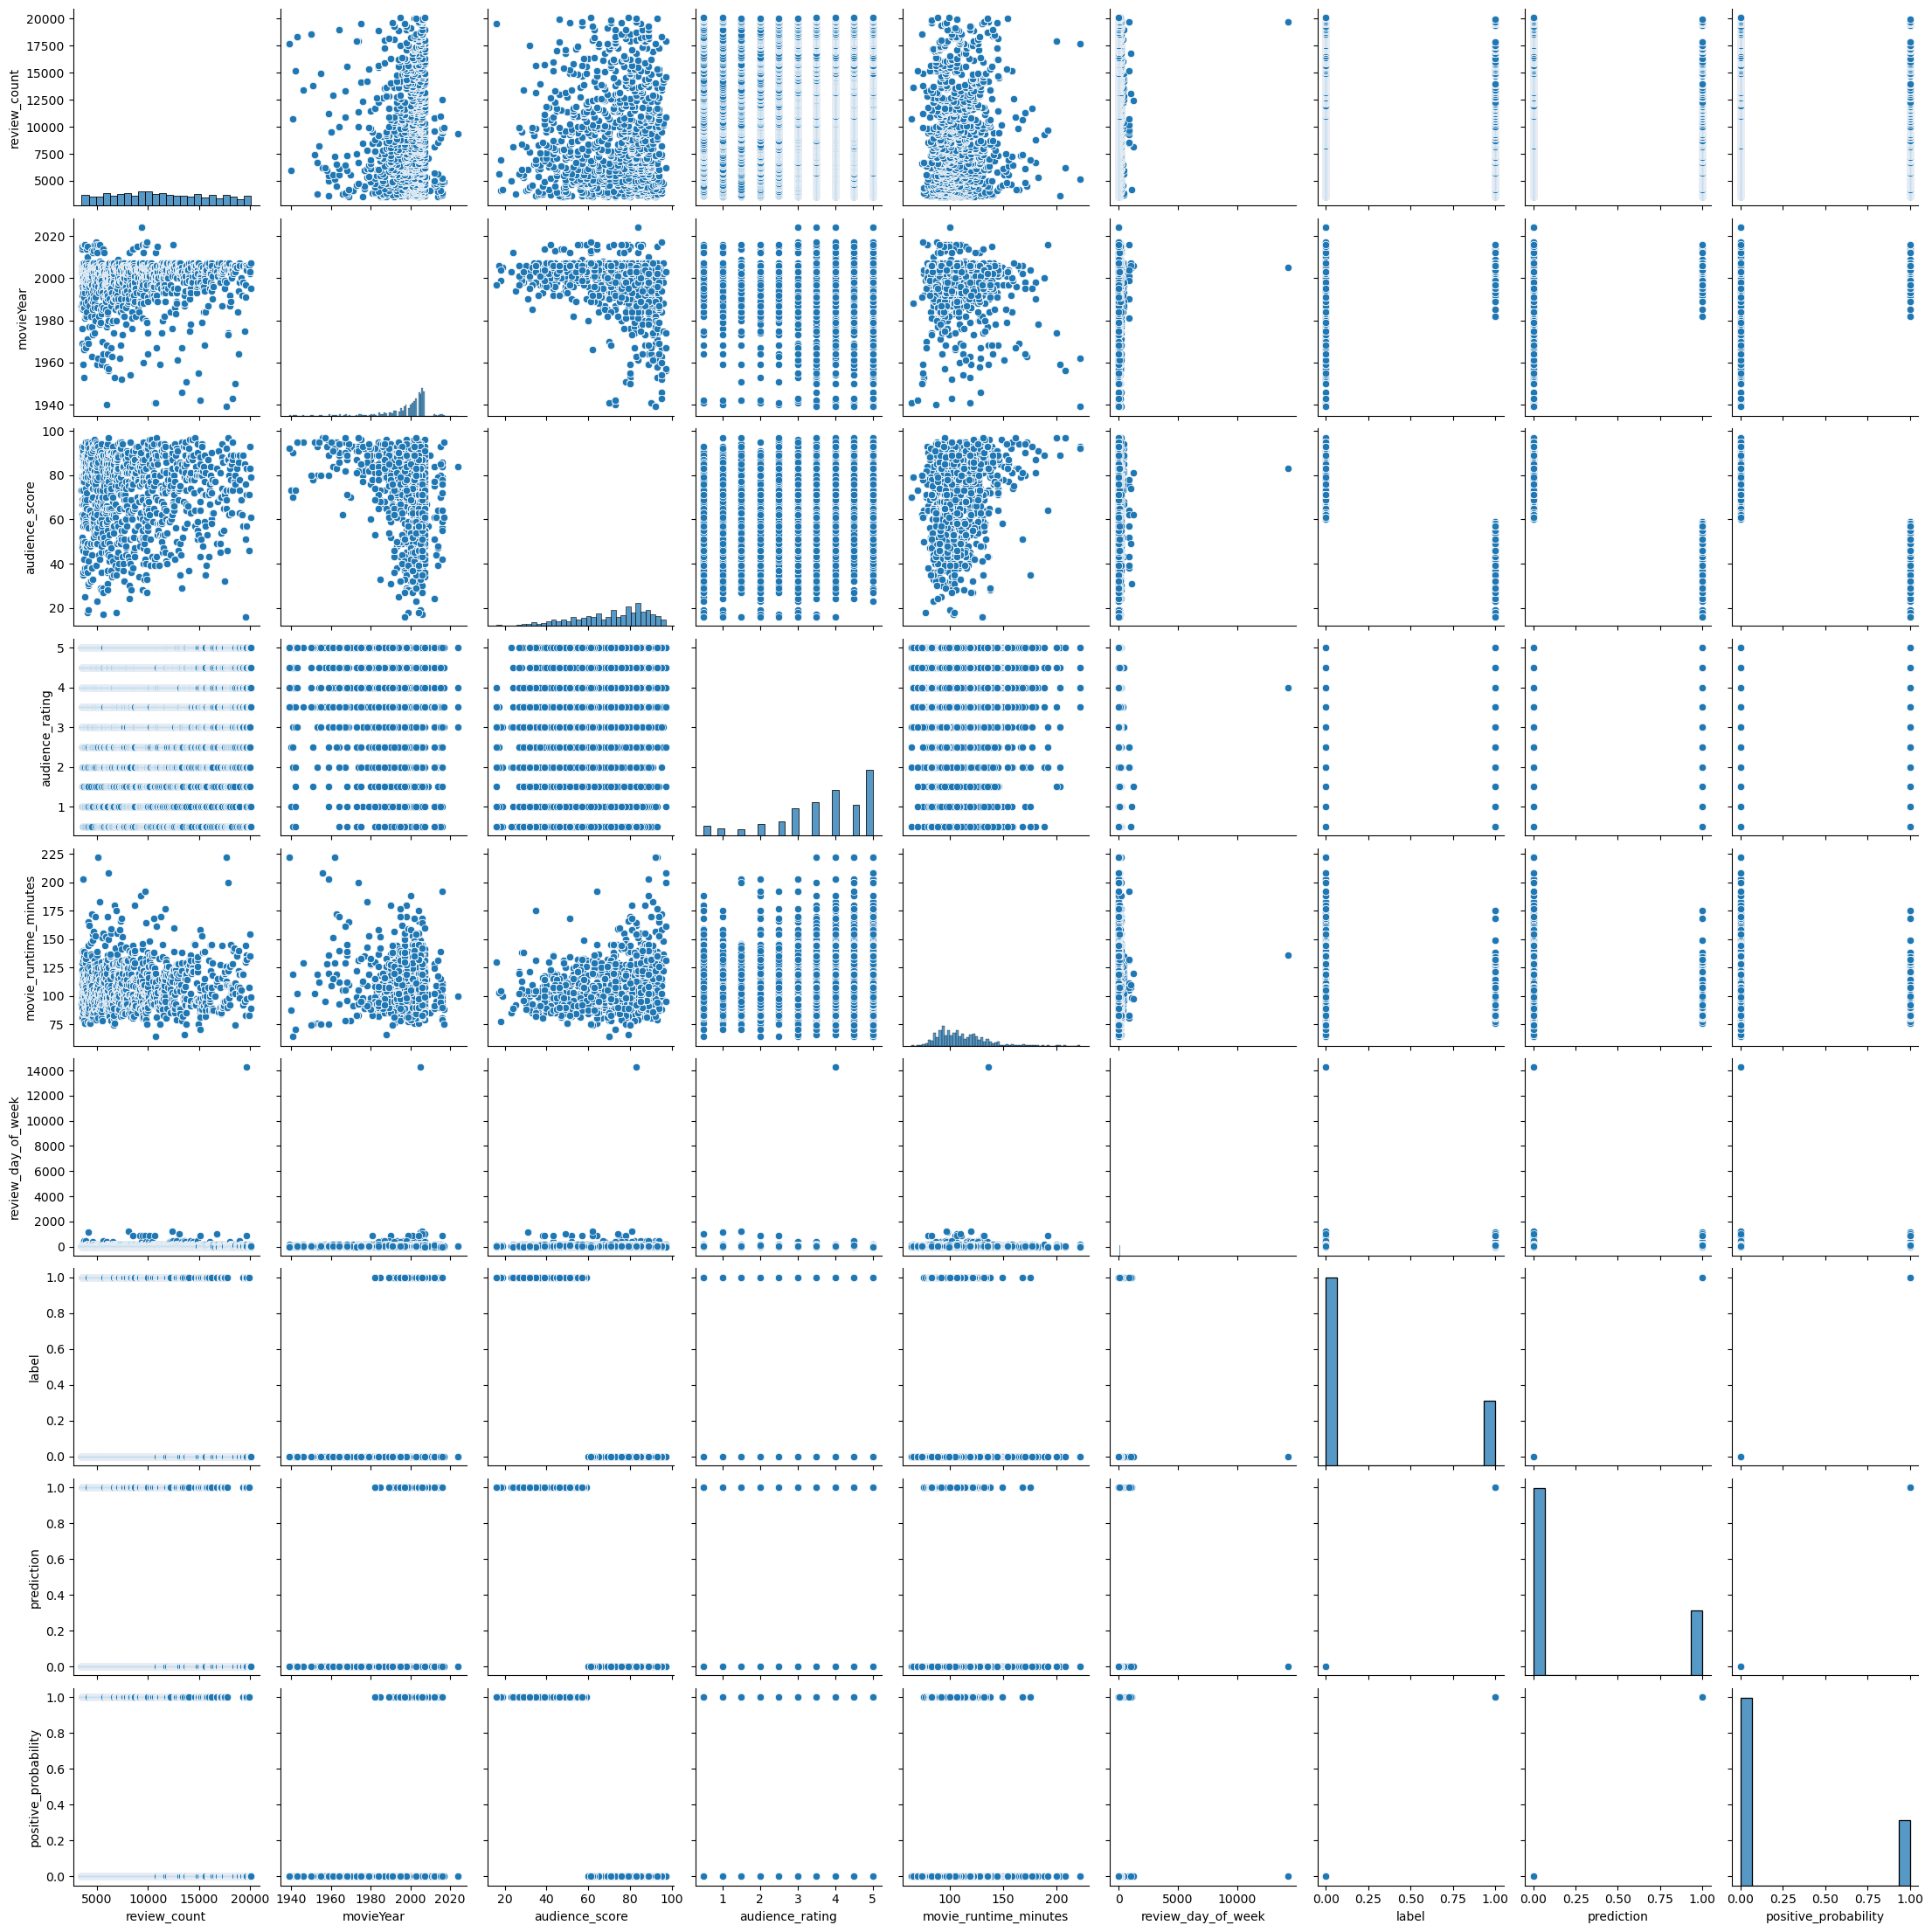

In [84]:
import seaborn as sns
sns.pairplot(pandas_df)

In [71]:
processed_data.printSchema()

root
 |-- review_count: long (nullable = true)
 |-- movieYear: integer (nullable = true)
 |-- movieTitle: string (nullable = true)
 |-- audience_score: double (nullable = true)
 |-- audience_sentiment: string (nullable = true)
 |-- movie_runtime: string (nullable = true)
 |-- audience_rating: float (nullable = true)
 |-- audience_quote: string (nullable = true)
 |-- audience_creationDate: string (nullable = true)
 |-- movie_runtime_minutes: integer (nullable = false)
 |-- audience_score_vector: vector (nullable = true)
 |-- audience_score_scaled: vector (nullable = true)
 |-- runtime_vector: vector (nullable = true)
 |-- total_runtime: vector (nullable = true)
 |-- audience_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- tfidf_features: vector (nullable = true)
 |-- review_day_of_week: double (nullable = false)
 |-- final_features: vector (nullable = true)
 |-- indexed_audience_sentiment: double (nullable =

In [56]:
predictions_pd = predictions.select("audience_sentiment", "prediction", "probability").toPandas()

25/01/23 01:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1377.7 KiB


/tmp/ipykernel_11586/4251059669.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


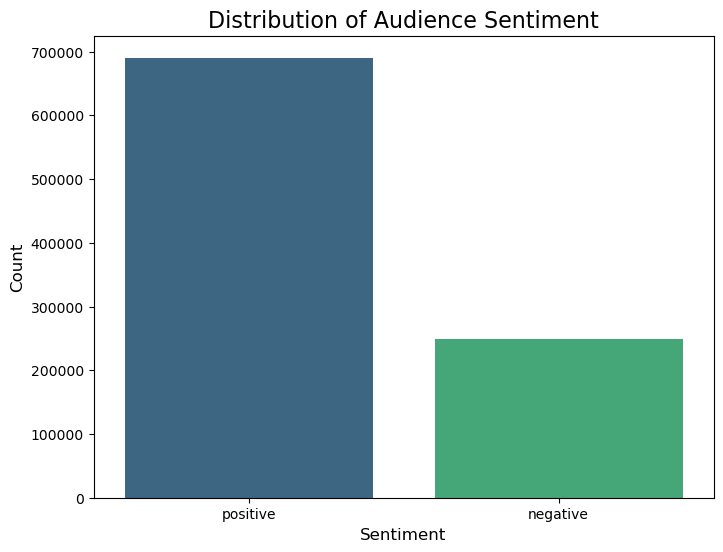

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = predictions_pd["audience_sentiment"].value_counts()

plt.figure(figsize = (8, 6))
sns.barplot(x = sentiment_counts.index, y = sentiment_counts.values, palette = "viridis")
plt.title("Distribution of Audience Sentiment", fontsize = 16)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()
